In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# ========================
# Cell 1: 라이브러리 Import
# ========================
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

print(" 라이브러리 로딩 완료")

 라이브러리 로딩 완료


In [20]:
# ========================
# Cell 2: 파일 경로 설정
# ========================
# Train 환자
train_mat_path = "/content/drive/MyDrive/p004352.mat"
train_patient_id = "p004255"

# Cross-subject test 환자
test_mat_path = "/content/drive/MyDrive/p005171.mat"
test_patient_id = "p005171"

epochs = 60
max_segments = 2000  # 정확히 2000개만 사용

print(f"Train 파일: {train_mat_path} ({train_patient_id})")
print(f"Test 파일: {test_mat_path} ({test_patient_id})")
print(f"학습 Epochs: {epochs}")
print(f"최대 세그먼트: {max_segments}")

Train 파일: /content/drive/MyDrive/p004352.mat (p004255)
Test 파일: /content/drive/MyDrive/p005171.mat (p005171)
학습 Epochs: 60
최대 세그먼트: 2000


In [21]:
def load_all_segments(mat_path, max_segments=2000, remove_outliers=True, outlier_threshold=3.0):
    print(f"\nLoading data from {mat_path}...")

    ppg_list, ecg_list, sbp_list, dbp_list = [], [], [], []

    with h5py.File(mat_path, 'r') as f:
        ppg_refs = f['Subj_Wins']['PPG_F'][0]
        ecg_refs = f['Subj_Wins']['ECG_F'][0]
        sbp_refs = f['Subj_Wins']['SegSBP'][0]
        dbp_refs = f['Subj_Wins']['SegDBP'][0]

        total_available = len(ppg_refs)
        print(f"   Total available segments: {total_available}")

        # 전체 로드 (초기에 2000으로 자르지 않음)
        for i in range(total_available):
            ppg = f[ppg_refs[i]][()].squeeze()
            ecg = f[ecg_refs[i]][()].squeeze()
            sbp = float(f[sbp_refs[i]][()][0, 0])
            dbp = float(f[dbp_refs[i]][()][0, 0])

            ppg_list.append(ppg)
            ecg_list.append(ecg)
            sbp_list.append(sbp)
            dbp_list.append(dbp)

    # 리스트 상태 유지(가변 길이 대비), 라벨은 float32
    ppg_data = ppg_list
    ecg_data = ecg_list
    sbp_labels = np.array(sbp_list, dtype=np.float32)
    dbp_labels = np.array(dbp_list, dtype=np.float32)

    print(f"Loaded {len(ppg_data)} segments (before cleaning)")
    print(f"   SBP range: {np.nanmin(sbp_labels):.1f} - {np.nanmax(sbp_labels):.1f} mmHg")
    print(f"   DBP range: {np.nanmin(dbp_labels):.1f} - {np.nanmax(dbp_labels):.1f} mmHg")

    # ---------- 수정 포인트: 안전한 유한성 검사 ----------
    def _is_finite_signal(x):
        # 비어있거나 캐스팅 불가 → 제외
        try:
            arr = np.asarray(x, dtype=np.float32)
        except Exception:
            return False
        if arr.size == 0:
            return False
        return np.isfinite(arr).all()  # float32이므로 안전

    signal_finite_mask = np.array([
        _is_finite_signal(ppg_data[i]) and _is_finite_signal(ecg_data[i])
        for i in range(len(ppg_data))
    ])

    label_finite_mask = np.isfinite(sbp_labels) & np.isfinite(dbp_labels)
    valid_mask = signal_finite_mask & label_finite_mask

    removed_bad = int(len(valid_mask) - valid_mask.sum())
    if removed_bad > 0:
        print(f"\n🧹 Removing {removed_bad} segments with NaN/Inf or non-numeric signals/labels")
        ppg_data = [ppg_data[i] for i in range(len(ppg_data)) if valid_mask[i]]
        ecg_data = [ecg_data[i] for i in range(len(ecg_data)) if valid_mask[i]]
        sbp_labels = sbp_labels[valid_mask]
        dbp_labels = dbp_labels[valid_mask]

    print(f"   After NaN/Inf removal: {len(ppg_data)} segments")

    # ---------- 이상치 제거 ----------
    if remove_outliers and len(ppg_data) > 0:
        sbp_mean, sbp_std = float(np.nanmean(sbp_labels)), float(np.nanstd(sbp_labels))
        dbp_mean, dbp_std = float(np.nanmean(dbp_labels)), float(np.nanstd(dbp_labels))

        if sbp_std == 0.0 or dbp_std == 0.0:
            print("\n Std of SBP/DBP is 0. Skipping outlier removal.")
        else:
            sbp_z = np.abs((sbp_labels - sbp_mean) / sbp_std)
            dbp_z = np.abs((dbp_labels - dbp_mean) / dbp_std)
            keep_mask = (sbp_z < outlier_threshold) & (dbp_z < outlier_threshold)

            outliers_removed = int(len(keep_mask) - keep_mask.sum())
            if outliers_removed > 0:
                print(f"\n Removing {outliers_removed} outliers (Z-score > {outlier_threshold})")
                ppg_data = [ppg_data[i] for i in range(len(ppg_data)) if keep_mask[i]]
                ecg_data = [ecg_data[i] for i in range(len(ecg_data)) if keep_mask[i]]
                sbp_labels = sbp_labels[keep_mask]
                dbp_labels = dbp_labels[keep_mask]

    if len(ppg_data) > 0:
        print(f" After outlier removal: {len(ppg_data)} segments")
        print(f"   SBP range: {np.min(sbp_labels):.1f} - {np.max(sbp_labels):.1f} mmHg")
        print(f"   DBP range: {np.min(dbp_labels):.1f} - {np.max(dbp_labels):.1f} mmHg")

    # ---------- 최종 2000개로 자르기 ----------
    if len(ppg_data) > max_segments:
        print(f"\n Trimming to exactly {max_segments} segments (after cleaning)")
        ppg_data = ppg_data[:max_segments]
        ecg_data = ecg_data[:max_segments]
        sbp_labels = sbp_labels[:max_segments]
        dbp_labels = dbp_labels[:max_segments]

    # 동일 길이면 float32 텐서로 변환 시도
    try:
        p_len = {len(x) for x in ppg_data}
        e_len = {len(x) for x in ecg_data}
        if len(p_len) == 1 and len(e_len) == 1:
            ppg_data = np.stack([np.asarray(x, dtype=np.float32) for x in ppg_data], axis=0)
            ecg_data = np.stack([np.asarray(x, dtype=np.float32) for x in ecg_data], axis=0)
        else:
            # 가변 길이면 object 유지
            ppg_data = np.array(ppg_data, dtype=object)
            ecg_data = np.array(ecg_data, dtype=object)
    except Exception:
        ppg_data = np.array(ppg_data, dtype=object)
        ecg_data = np.array(ecg_data, dtype=object)

    print(f"\n   Final PPG shape: {np.shape(ppg_data)}")
    print(f"   Final ECG shape: {np.shape(ecg_data)}")

    return ppg_data, ecg_data, sbp_labels, dbp_labels


In [22]:
# ========================
# Cell 4: 데이터 로딩 실행
# ========================
import os

# 파일 존재 여부 확인
if not os.path.exists(train_mat_path):
    print(f"오류: Train 파일 '{train_mat_path}'을(를) 찾을 수 없습니다.")
    print("Google Drive의 '내 드라이브' 폴더 아래에 'p004352.mat' 파일이 있는지 확인하거나 경로를 수정해주세요.")
    print("현재 디렉토리와 드라이브 경로의 파일 목록을 확인합니다...")
    !ls -F "/content/drive/MyDrive/"
    raise FileNotFoundError(f"Train 파일 없음: {train_mat_path}")

# Train 환자 데이터
train_ppg, train_ecg, train_sbp, train_dbp = load_all_segments(
    train_mat_path,
    max_segments=max_segments,
    remove_outliers=True,
    outlier_threshold=3.0
)

# Test 환자 데이터 (Cross-subject)
if not os.path.exists(test_mat_path):
    print(f"오류: Test 파일 '{test_mat_path}'을(를) 찾을 수 없습니다.")
    print("Google Drive의 '내 드라이브' 폴더 아래에 'p005171.mat' 파일이 있는지 확인하거나 경로를 수정해주세요.")
    !ls -F "/content/drive/MyDrive/"
    raise FileNotFoundError(f"Test 파일 없음: {test_mat_path}")

test_ppg, test_ecg, test_sbp, test_dbp = load_all_segments(
    test_mat_path,
    max_segments=max_segments,
    remove_outliers=True,
    outlier_threshold=3.0
)


Loading data from /content/drive/MyDrive/p004352.mat...
   Total available segments: 2248
Loaded 2248 segments (before cleaning)
   SBP range: 68.8 - 250.8 mmHg
   DBP range: 33.2 - 246.2 mmHg
   After NaN/Inf removal: 2248 segments

 Removing 7 outliers (Z-score > 3.0)
 After outlier removal: 2241 segments
   SBP range: 70.4 - 142.2 mmHg
   DBP range: 33.2 - 80.3 mmHg

 Trimming to exactly 2000 segments (after cleaning)

   Final PPG shape: (2000, 1250)
   Final ECG shape: (2000, 1250)

Loading data from /content/drive/MyDrive/p005171.mat...
   Total available segments: 2292
Loaded 2292 segments (before cleaning)
   SBP range: 75.9 - 234.0 mmHg
   DBP range: 51.9 - 225.8 mmHg
   After NaN/Inf removal: 2292 segments

 Removing 25 outliers (Z-score > 3.0)
 After outlier removal: 2267 segments
   SBP range: 89.3 - 167.6 mmHg
   DBP range: 54.2 - 92.0 mmHg

 Trimming to exactly 2000 segments (after cleaning)

   Final PPG shape: (2000, 1250)
   Final ECG shape: (2000, 1250)


In [23]:
# ========================
# Cell 5: 혈압 시각화 함수 정의
# ========================
def plot_bp_combined_timeseries(sbp_list, dbp_list, patient_id, title_suffix=""):
    """SBP와 DBP를 하나의 그래프에 표시"""
    time_idx = np.arange(len(sbp_list))

    fig = plt.figure(figsize=(16, 6), facecolor='white')
    ax = fig.add_subplot(111, facecolor='white')

    # SBP와 DBP 라인 플롯
    ax.plot(time_idx, sbp_list, color='red', linewidth=1.5,
            marker='o', markersize=2, alpha=0.8, label='SBP (Systolic)')
    ax.plot(time_idx, dbp_list, color='blue', linewidth=1.5,
            marker='s', markersize=2, alpha=0.8, label='DBP (Diastolic)')

    # 평균선
    ax.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
               linewidth=2, alpha=0.7, label=f'SBP Mean: {np.mean(sbp_list):.1f} mmHg')
    ax.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
               linewidth=2, alpha=0.7, label=f'DBP Mean: {np.mean(dbp_list):.1f} mmHg')

    # 기준선
    ax.axhline(130, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='High-Normal (130)')
    ax.axhline(140, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Hypertension (140)')
    ax.axhline(80, color='lightblue', linestyle='--', linewidth=1.5, alpha=0.5, label='DBP High-Normal (80)')

    # 영역 채우기 (맥압 표시)
    ax.fill_between(time_idx, sbp_list, dbp_list, alpha=0.1, color='purple',
                    label='Pulse Pressure')

    ax.set_xlabel('Segment Index (Time Sequence)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Blood Pressure (mmHg)', fontsize=13, fontweight='bold')
    ax.set_title(f'Blood Pressure Variation - Patient {patient_id} {title_suffix}',
                 fontsize=15, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, frameon=True, facecolor='white')
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    plt.tight_layout()
    plt.savefig(f'{patient_id}_blood_pressure_timeseries.png', dpi=150, bbox_inches='tight')
    plt.show()

    # 통계 출력
    print(f"\n {patient_id} 혈압 통계:")
    print(f"   SBP: {np.mean(sbp_list):.1f} ± {np.std(sbp_list):.1f} mmHg (범위: {np.min(sbp_list):.1f}-{np.max(sbp_list):.1f})")
    print(f"   DBP: {np.mean(dbp_list):.1f} ± {np.std(dbp_list):.1f} mmHg (범위: {np.min(dbp_list):.1f}-{np.max(dbp_list):.1f})")

print("혈압 시각화 함수 정의 완료")

혈압 시각화 함수 정의 완료



Train Patient: p004255


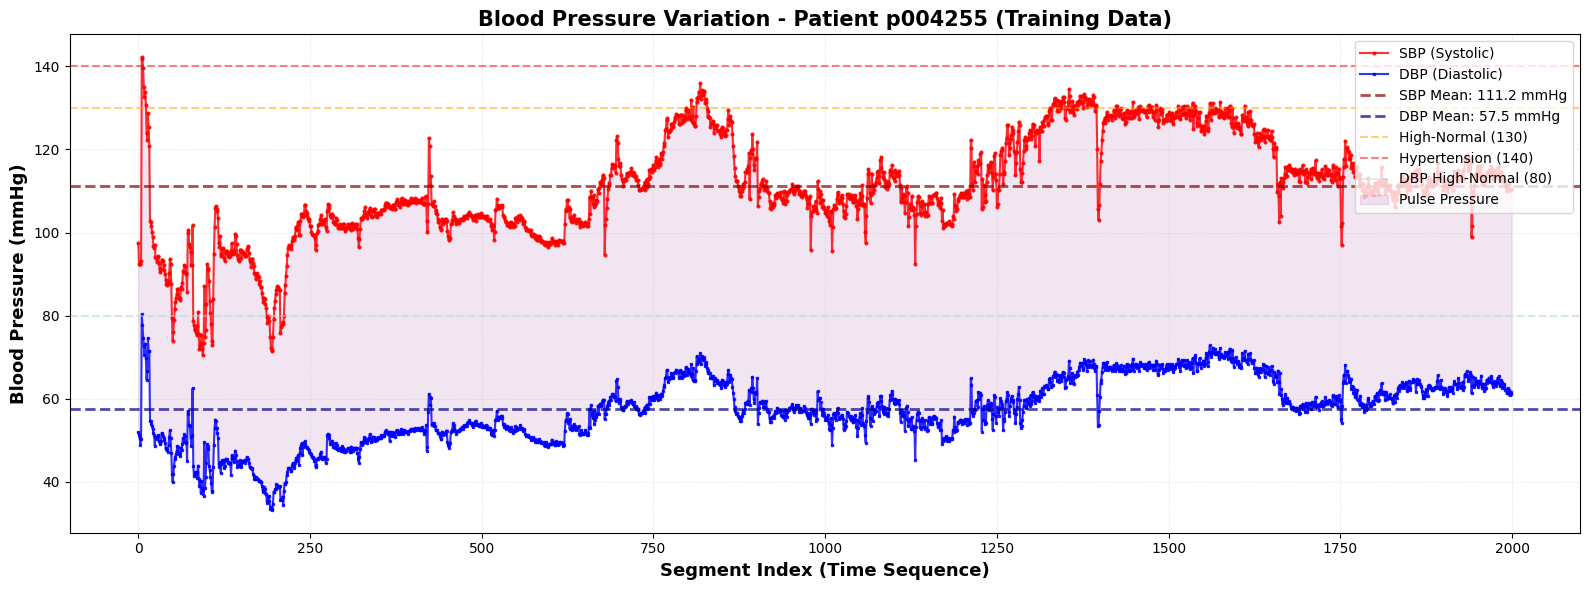


 p004255 혈압 통계:
   SBP: 111.2 ± 12.3 mmHg (범위: 70.4-142.2)
   DBP: 57.5 ± 7.8 mmHg (범위: 33.2-80.3)


In [24]:
# ========================
# Cell 6: Train 환자 혈압 시각화
# ========================
print(f"\n{'='*70}")
print(f"Train Patient: {train_patient_id}")
print(f"{'='*70}")
plot_bp_combined_timeseries(train_sbp, train_dbp, train_patient_id, "(Training Data)")


Test Patient: p005171


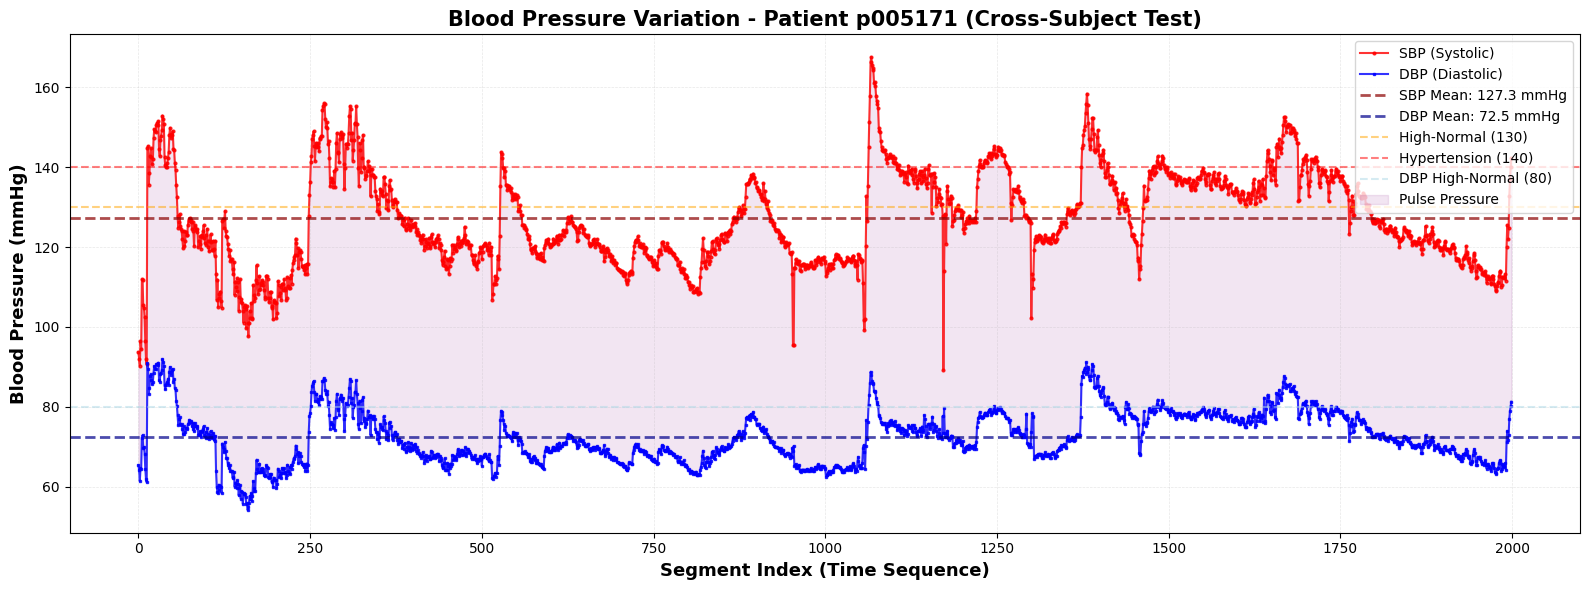


 p005171 혈압 통계:
   SBP: 127.3 ± 11.8 mmHg (범위: 89.3-167.6)
   DBP: 72.5 ± 6.5 mmHg (범위: 54.2-92.0)


In [25]:
# ========================
# Cell 7: Test 환자 혈압 시각화
# ========================
print(f"\n{'='*70}")
print(f"Test Patient: {test_patient_id}")
print(f"{'='*70}")
plot_bp_combined_timeseries(test_sbp, test_dbp, test_patient_id, "(Cross-Subject Test)")

In [26]:
# ========================
# Cell 8: 4-Fold 데이터 분할 함수 정의
# ========================
def create_4fold_splits(ppg_data, ecg_data, sbp_labels, dbp_labels):
    """
    시간 순서를 유지하며 4-Fold로 분할
    각 Fold: 400 (train) + 100 (test) = 500 segments
    Total: 2000 segments (정확히)
    """
    assert len(ppg_data) == 2000, f"Data must be exactly 2000 segments, got {len(ppg_data)}"

    print(f"\n{'='*60}")
    print(f"Creating 4-Fold splits for {len(ppg_data)} segments")
    print(f"{'='*60}")

    fold_size = 500  # 각 fold당 500개
    train_size = 400
    test_size = 100

    folds = []

    for fold_idx in range(4):
        start_idx = fold_idx * fold_size
        end_idx = start_idx + fold_size

        # 현재 fold의 데이터
        fold_ppg = ppg_data[start_idx:end_idx]
        fold_ecg = ecg_data[start_idx:end_idx]
        fold_sbp = sbp_labels[start_idx:end_idx]
        fold_dbp = dbp_labels[start_idx:end_idx]

        # Train (0-400), Test (400-500)
        train_ppg = fold_ppg[:train_size]
        train_ecg = fold_ecg[:train_size]
        train_sbp = fold_sbp[:train_size]
        train_dbp = fold_dbp[:train_size]

        test_ppg = fold_ppg[train_size:train_size + test_size]
        test_ecg = fold_ecg[train_size:train_size + test_size]
        test_sbp = fold_sbp[train_size:train_size + test_size]
        test_dbp = fold_dbp[train_size:train_size + test_size]

        fold_data = {
            'train': (train_ppg, train_ecg, train_sbp, train_dbp),
            'test': (test_ppg, test_ecg, test_sbp, test_dbp)
        }

        folds.append(fold_data)

        print(f"Fold {fold_idx + 1}: Train={len(train_ppg)}, Test={len(test_ppg)}")

    print(f"\ Total: 2000 segments split into 4 folds")
    print(f"{'='*60}\n")

    return folds

print(" 4-Fold 분할 함수 정의 완료")

 4-Fold 분할 함수 정의 완료


In [27]:
# ========================
# Cell 9: 4-Fold 분할 실행
# ========================
folds = create_4fold_splits(train_ppg, train_ecg, train_sbp, train_dbp)


Creating 4-Fold splits for 2000 segments
Fold 1: Train=400, Test=100
Fold 2: Train=400, Test=100
Fold 3: Train=400, Test=100
Fold 4: Train=400, Test=100
\ Total: 2000 segments split into 4 folds



In [28]:
# ========================
# Cell 10: 모델 구축 함수 정의 (개선)
# ========================
def build_cnn_model(input_shape, model_name='CNN'):
    """개선된 CNN 모델 - 더 깊고 안정적"""
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = layers.Conv1D(64, 15, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(64, 15, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)

    # Block 2
    x = layers.Conv1D(128, 9, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(128, 9, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    # Block 3
    x = layers.Conv1D(256, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(256, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    # Block 4
    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(64, activation='relu')(x)

    sbp_output = layers.Dense(1, name='sbp')(x)
    dbp_output = layers.Dense(1, name='dbp')(x)

    model = keras.Model(inputs=inputs, outputs=[sbp_output, dbp_output], name=model_name)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0003),
        loss={'sbp': 'huber', 'dbp': 'huber'},  # Huber loss는 outlier에 더 robust
        metrics={'sbp': 'mae', 'dbp': 'mae'}
    )

    return model


def build_cnn_lstm_model(input_shape, model_name='CNN_LSTM'):
    """개선된 CNN + LSTM 하이브리드 모델"""
    inputs = keras.Input(shape=input_shape)

    # CNN feature extraction
    x = layers.Conv1D(64, 15, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(128, 9, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(256, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dropout(0.4)(x)

    # Dense layers
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(64, activation='relu')(x)

    sbp_output = layers.Dense(1, name='sbp')(x)
    dbp_output = layers.Dense(1, name='dbp')(x)

    model = keras.Model(inputs=inputs, outputs=[sbp_output, dbp_output], name=model_name)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0003),
        loss={'sbp': 'huber', 'dbp': 'huber'},
        metrics={'sbp': 'mae', 'dbp': 'mae'}
    )

    return model


def build_resnet_model(input_shape, model_name='ResNet'):
    """ResNet 스타일 모델"""
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv1D(64, 11, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)

    # Residual Block 1
    shortcut = x
    x = layers.Conv1D(64, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(64, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)

    # Residual Block 2
    shortcut = layers.Conv1D(128, 1, padding='same')(x)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Conv1D(128, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(128, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)

    # Residual Block 3
    shortcut = layers.Conv1D(256, 1, padding='same')(x)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Conv1D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)

    sbp_output = layers.Dense(1, name='sbp')(x)
    dbp_output = layers.Dense(1, name='dbp')(x)

    model = keras.Model(inputs=inputs, outputs=[sbp_output, dbp_output], name=model_name)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss={'sbp': 'mse', 'dbp': 'mse'},
        metrics={'sbp': 'mae', 'dbp': 'mae'}
    )

    return model

print("모델 구축 함수 정의 완료 (CNN, CNN+LSTM, ResNet)")

모델 구축 함수 정의 완료 (CNN, CNN+LSTM, ResNet)


In [29]:
# ========================
# Cell 11: 학습 및 평가 함수 정의
# ========================
def train_and_evaluate_fold(fold_data, model_builder, model_name, input_type='ecg_ppg', fold_idx=0, epochs=100):
    """한 Fold에 대해 학습 및 평가"""
    train_ppg, train_ecg, train_sbp, train_dbp = fold_data['train']
    test_ppg, test_ecg, test_sbp, test_dbp = fold_data['test']

    # 데이터 준비
    if input_type == 'ecg_ppg':
        train_X = np.stack([train_ppg, train_ecg], axis=-1)
        test_X = np.stack([test_ppg, test_ecg], axis=-1)
        input_shape = (1250, 2)
    else:
        train_X = train_ppg[..., np.newaxis]
        test_X = test_ppg[..., np.newaxis]
        input_shape = (1250, 1)

    train_Y = {'sbp': train_sbp, 'dbp': train_dbp}

    # 모델 생성
    model = model_builder(input_shape, model_name=model_name)

    # 학습
    print(f"\n{'='*60}")
    print(f"Training Fold {fold_idx + 1} - {model_name} ({input_type})")
    print(f"{'='*60}")

    history = model.fit(
        train_X, train_Y,
        epochs=epochs,
        batch_size=32,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=0),
            keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=7, verbose=0, min_lr=1e-6)
        ]
    )

    # 테스트 예측
    predictions = model.predict(test_X, verbose=0)
    pred_sbp = predictions[0].squeeze()
    pred_dbp = predictions[1].squeeze()

    sbp_mae = mean_absolute_error(test_sbp, pred_sbp)
    sbp_rmse = np.sqrt(mean_squared_error(test_sbp, pred_sbp))
    dbp_mae = mean_absolute_error(test_dbp, pred_dbp)
    dbp_rmse = np.sqrt(mean_squared_error(test_dbp, pred_dbp))

    results = {
        'sbp_mae': sbp_mae,
        'sbp_rmse': sbp_rmse,
        'dbp_mae': dbp_mae,
        'dbp_rmse': dbp_rmse,
        'model': model
    }

    print(f" Fold {fold_idx + 1} Results:")
    print(f"   SBP: MAE={sbp_mae:.3f}, RMSE={sbp_rmse:.3f}")
    print(f"   DBP: MAE={dbp_mae:.3f}, RMSE={dbp_rmse:.3f}")

    return results


def run_4fold_cross_validation(folds, model_builder, model_name, input_type='ecg_ppg', epochs=100):
    """4-Fold Cross Validation 실행"""
    all_results = []

    for fold_idx, fold_data in enumerate(folds):
        results = train_and_evaluate_fold(fold_data, model_builder, model_name, input_type, fold_idx, epochs)
        all_results.append(results)

    return all_results

print(" 학습 및 평가 함수 정의 완료")

 학습 및 평가 함수 정의 완료


In [30]:
# ========================
# Cell 12: 결과 요약 함수 정의
# ========================
def summarize_results(all_results, model_name='Model'):
    """4-Fold 결과 요약"""
    sbp_maes = [r['sbp_mae'] for r in all_results]
    sbp_rmses = [r['sbp_rmse'] for r in all_results]
    dbp_maes = [r['dbp_mae'] for r in all_results]
    dbp_rmses = [r['dbp_rmse'] for r in all_results]

    print(f"\n{'='*80}")
    print(f" 4-Fold Cross Validation Results - {model_name}")
    print(f"{'='*80}")
    print(f"\n{'Fold':<10}{'SBP MAE':<15}{'SBP RMSE':<15}{'DBP MAE':<15}{'DBP RMSE':<15}")
    print(f"{'-'*80}")

    for i in range(4):
        print(f"Fold {i+1:<5}{sbp_maes[i]:<15.3f}{sbp_rmses[i]:<15.3f}"
              f"{dbp_maes[i]:<15.3f}{dbp_rmses[i]:<15.3f}")

    print(f"{'-'*80}")
    print(f"{'Mean':<10}{np.mean(sbp_maes):<15.3f}{np.mean(sbp_rmses):<15.3f}"
          f"{np.mean(dbp_maes):<15.3f}{np.mean(dbp_rmses):<15.3f}")
    print(f"{'Std':<10}{np.std(sbp_maes):<15.3f}{np.std(sbp_rmses):<15.3f}"
          f"{np.std(dbp_maes):<15.3f}{np.std(dbp_rmses):<15.3f}")
    print(f"{'='*80}\n")

    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    fold_nums = range(1, 5)

    axes[0, 0].bar(fold_nums, sbp_maes, color='steelblue', alpha=0.7)
    axes[0, 0].axhline(y=np.mean(sbp_maes), color='r', linestyle='--', label=f'Mean: {np.mean(sbp_maes):.3f}')
    axes[0, 0].set_title(f'SBP MAE per Fold - {model_name}', fontweight='bold')
    axes[0, 0].set_xlabel('Fold')
    axes[0, 0].set_ylabel('MAE (mmHg)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].bar(fold_nums, sbp_rmses, color='coral', alpha=0.7)
    axes[0, 1].axhline(y=np.mean(sbp_rmses), color='r', linestyle='--', label=f'Mean: {np.mean(sbp_rmses):.3f}')
    axes[0, 1].set_title(f'SBP RMSE per Fold - {model_name}', fontweight='bold')
    axes[0, 1].set_xlabel('Fold')
    axes[0, 1].set_ylabel('RMSE (mmHg)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].bar(fold_nums, dbp_maes, color='lightgreen', alpha=0.7)
    axes[1, 0].axhline(y=np.mean(dbp_maes), color='r', linestyle='--', label=f'Mean: {np.mean(dbp_maes):.3f}')
    axes[1, 0].set_title(f'DBP MAE per Fold - {model_name}', fontweight='bold')
    axes[1, 0].set_xlabel('Fold')
    axes[1, 0].set_ylabel('MAE (mmHg)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].bar(fold_nums, dbp_rmses, color='plum', alpha=0.7)
    axes[1, 1].axhline(y=np.mean(dbp_rmses), color='r', linestyle='--', label=f'Mean: {np.mean(dbp_rmses):.3f}')
    axes[1, 1].set_title(f'DBP RMSE per Fold - {model_name}', fontweight='bold')
    axes[1, 1].set_xlabel('Fold')
    axes[1, 1].set_ylabel('RMSE (mmHg)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_name.replace("+", "_").replace(" ", "_")}_4fold_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    return {
        'sbp_mae_mean': np.mean(sbp_maes),
        'sbp_mae_std': np.std(sbp_maes),
        'sbp_rmse_mean': np.mean(sbp_rmses),
        'sbp_rmse_std': np.std(sbp_rmses),
        'dbp_mae_mean': np.mean(dbp_maes),
        'dbp_mae_std': np.std(dbp_maes),
        'dbp_rmse_mean': np.mean(dbp_rmses),
        'dbp_rmse_std': np.std(dbp_rmses)
    }

print(" 결과 요약 함수 정의 완료")

 결과 요약 함수 정의 완료


In [31]:
# ========================
# Cell 13: Model 1 - CNN (ECG+PPG) 학습
# ========================
print(f"\n{'#'*70}")
print("# Model 1: CNN (ECG+PPG)")
print(f"{'#'*70}")
results_cnn_ecg_ppg = run_4fold_cross_validation(
    folds,
    build_cnn_model,
    'CNN',
    input_type='ecg_ppg',
    epochs=epochs
)


######################################################################
# Model 1: CNN (ECG+PPG)
######################################################################

Training Fold 1 - CNN (ecg_ppg)
 Fold 1 Results:
   SBP: MAE=12.529, RMSE=14.471
   DBP: MAE=8.195, RMSE=8.851

Training Fold 2 - CNN (ecg_ppg)
 Fold 2 Results:
   SBP: MAE=12.391, RMSE=13.636
   DBP: MAE=6.015, RMSE=6.643

Training Fold 3 - CNN (ecg_ppg)
 Fold 3 Results:
   SBP: MAE=9.315, RMSE=9.796
   DBP: MAE=2.026, RMSE=3.080

Training Fold 4 - CNN (ecg_ppg)
 Fold 4 Results:
   SBP: MAE=5.720, RMSE=6.526
   DBP: MAE=5.715, RMSE=5.960



 4-Fold Cross Validation Results - CNN (ECG+PPG)

Fold      SBP MAE        SBP RMSE       DBP MAE        DBP RMSE       
--------------------------------------------------------------------------------
Fold 1    12.529         14.471         8.195          8.851          
Fold 2    12.391         13.636         6.015          6.643          
Fold 3    9.315          9.796          2.026          3.080          
Fold 4    5.720          6.526          5.715          5.960          
--------------------------------------------------------------------------------
Mean      9.989          11.107         5.488          6.134          
Std       2.779          3.179          2.216          2.061          



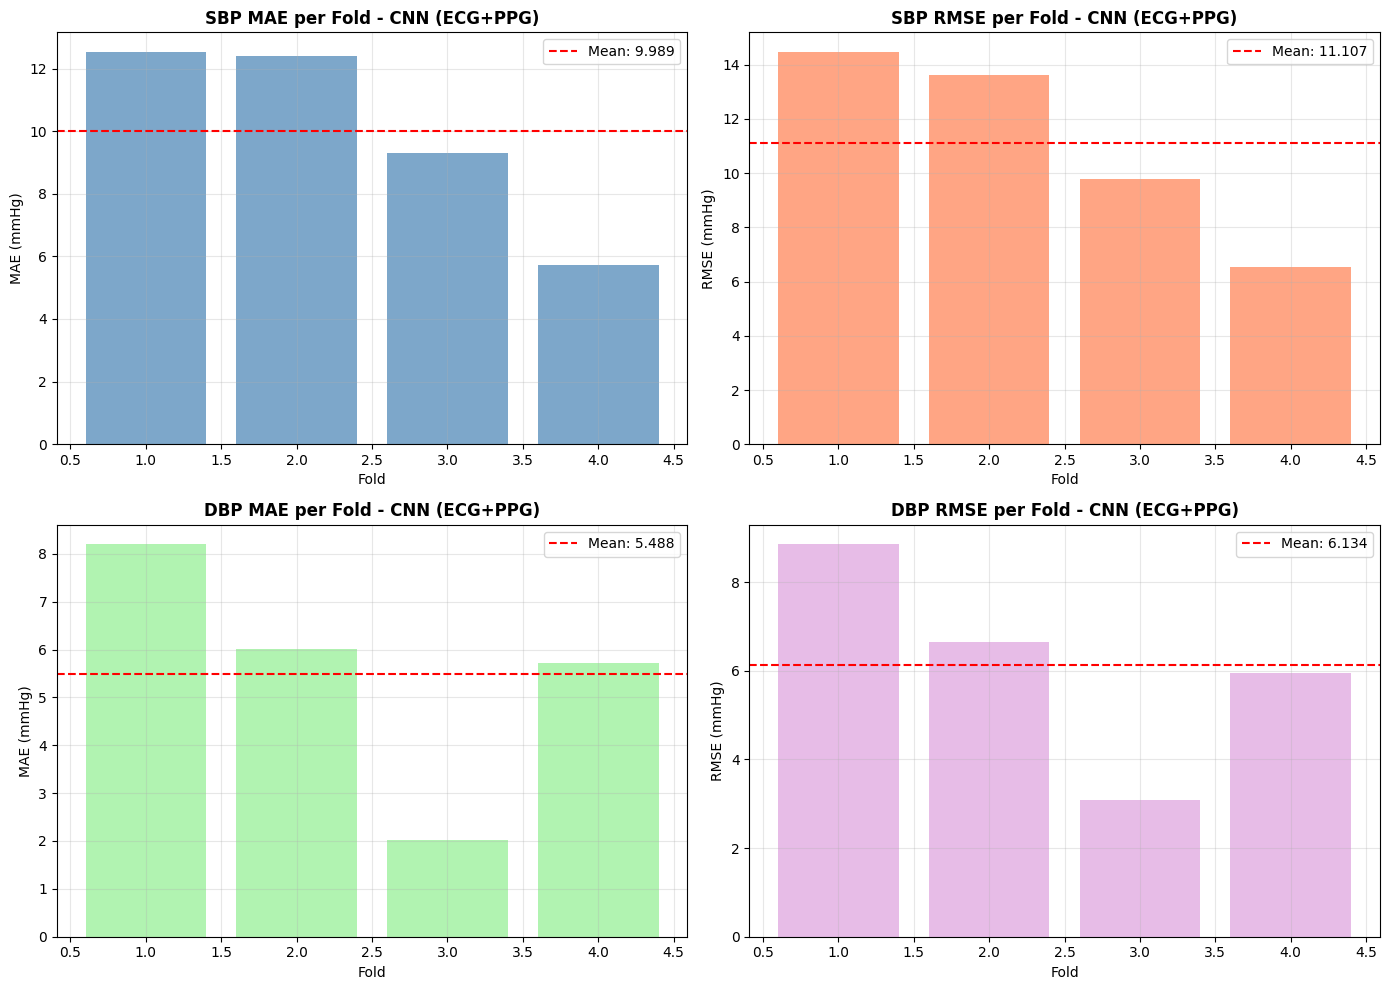

In [32]:
# ========================
# Cell 14: Model 1 결과 요약
# ========================
summary_cnn_ecg_ppg = summarize_results(results_cnn_ecg_ppg, model_name='CNN (ECG+PPG)')

In [33]:
# ========================
# Cell 15: Model 2 - CNN (PPG only) 학습
# ========================
print(f"\n{'#'*70}")
print("# Model 2: CNN (PPG only)")
print(f"{'#'*70}")
results_cnn_ppg = run_4fold_cross_validation(
    folds,
    build_cnn_model,
    'CNN',
    input_type='ppg_only',
    epochs=epochs
)


######################################################################
# Model 2: CNN (PPG only)
######################################################################

Training Fold 1 - CNN (ppg_only)
 Fold 1 Results:
   SBP: MAE=12.508, RMSE=16.158
   DBP: MAE=7.609, RMSE=9.066

Training Fold 2 - CNN (ppg_only)
 Fold 2 Results:
   SBP: MAE=5.117, RMSE=6.222
   DBP: MAE=3.152, RMSE=3.836

Training Fold 3 - CNN (ppg_only)
 Fold 3 Results:
   SBP: MAE=4.595, RMSE=6.486
   DBP: MAE=6.390, RMSE=6.801

Training Fold 4 - CNN (ppg_only)
 Fold 4 Results:
   SBP: MAE=6.360, RMSE=7.685
   DBP: MAE=4.136, RMSE=4.872



 4-Fold Cross Validation Results - CNN (PPG only)

Fold      SBP MAE        SBP RMSE       DBP MAE        DBP RMSE       
--------------------------------------------------------------------------------
Fold 1    12.508         16.158         7.609          9.066          
Fold 2    5.117          6.222          3.152          3.836          
Fold 3    4.595          6.486          6.390          6.801          
Fold 4    6.360          7.685          4.136          4.872          
--------------------------------------------------------------------------------
Mean      7.145          9.138          5.322          6.144          
Std       3.162          4.090          1.767          1.995          



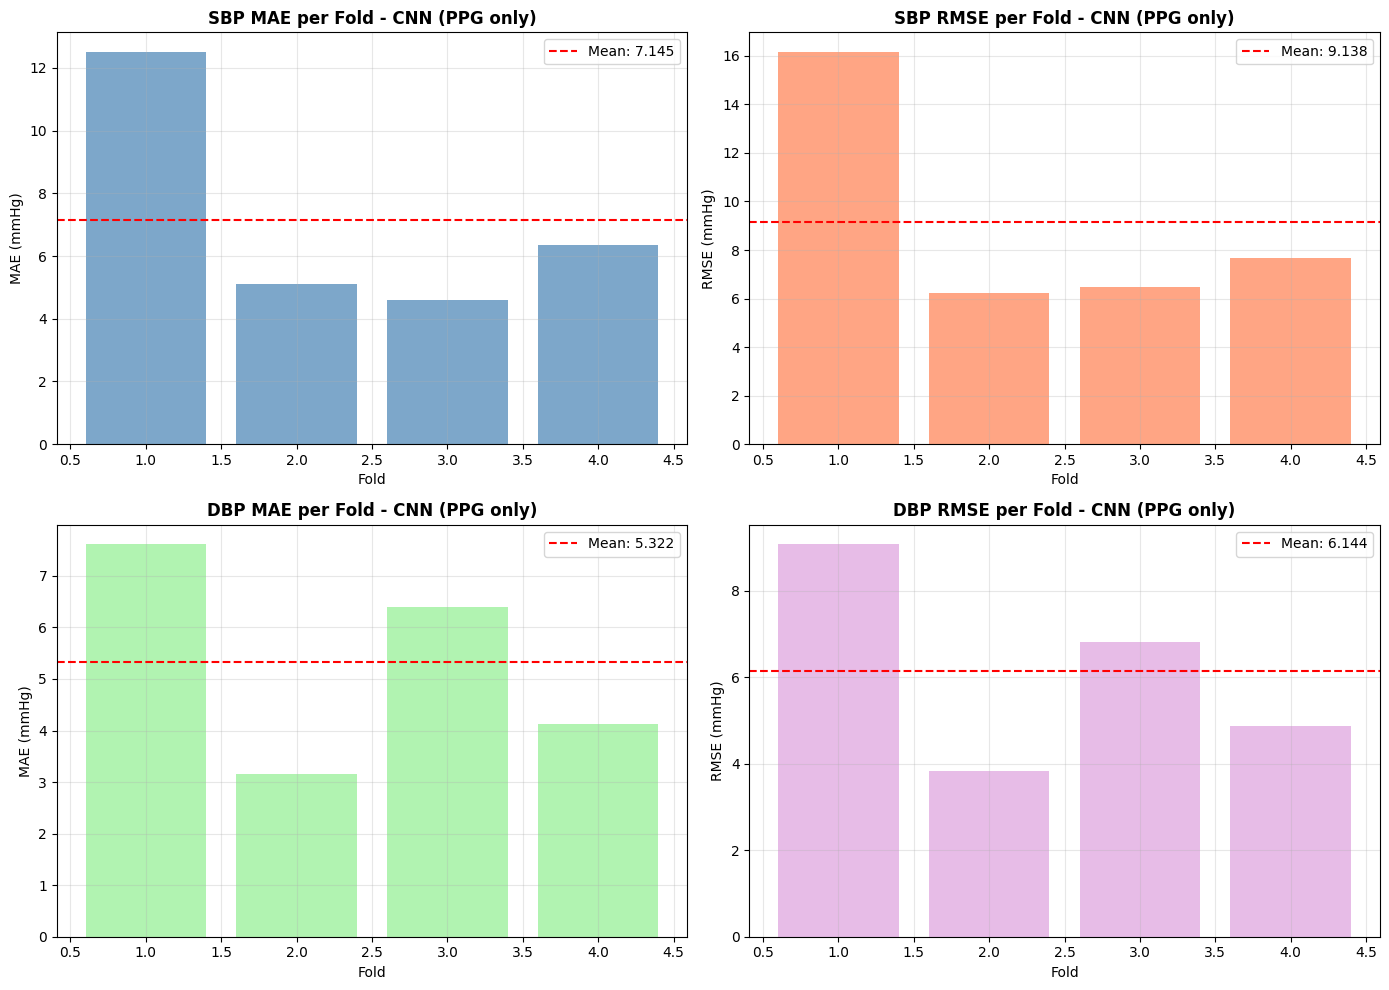

In [34]:
# ========================
# Cell 16: Model 2 결과 요약
# ========================
summary_cnn_ppg = summarize_results(results_cnn_ppg, model_name='CNN (PPG only)')

In [ ]:
# ========================
# Cell 17: Model 3 - CNN+LSTM (ECG+PPG) 학습
# ========================
print(f"\n{'#'*70}")
print("# Model 3: CNN+LSTM (ECG+PPG)")
print(f"{'#'*70}")
results_cnn_lstm_ecg_ppg = run_4fold_cross_validation(
    folds,
    build_cnn_lstm_model,
    'CNN_LSTM',
    input_type='ecg_ppg',
    epochs=epochs
)


######################################################################
# Model 3: CNN+LSTM (ECG+PPG)
######################################################################

Training Fold 1 - CNN_LSTM (ecg_ppg)
 Fold 1 Results:
   SBP: MAE=10.719, RMSE=14.523
   DBP: MAE=6.743, RMSE=8.408

Training Fold 2 - CNN_LSTM (ecg_ppg)
 Fold 2 Results:
   SBP: MAE=3.059, RMSE=4.619
   DBP: MAE=2.534, RMSE=3.214

Training Fold 3 - CNN_LSTM (ecg_ppg)


In [ ]:
# ========================
# Cell 18: Model 3 결과 요약
# ========================
summary_cnn_lstm_ecg_ppg = summarize_results(results_cnn_lstm_ecg_ppg, model_name='CNN+LSTM (ECG+PPG)')

In [ ]:
# ========================
# Cell 19: Model 4 - ResNet (ECG+PPG) 학습
# ========================
print(f"\n{'#'*70}")
print("# Model 4: ResNet (ECG+PPG)")
print(f"{'#'*70}")
results_resnet_ecg_ppg = run_4fold_cross_validation(
    folds,
    build_resnet_model,
    'ResNet',
    input_type='ecg_ppg',
    epochs=epochs
)

In [ ]:
# ========================
# Cell 20: Model 4 결과 요약
# ========================
summary_resnet_ecg_ppg = summarize_results(results_resnet_ecg_ppg, model_name='ResNet (ECG+PPG)')

In [ ]:
# ========================
# Cell 21: Cross-Subject 테스트 함수 정의
# ========================
def cross_subject_test(trained_model, test_ppg, test_ecg, test_sbp, test_dbp,
                       input_type='ecg_ppg', train_patient='p004255', test_patient='p005227'):
    """
    한 환자로 학습한 모델을 다른 환자에게 적용
    """
    print(f"\n{'='*70}")
    print(f"Cross-Subject Test: {train_patient} → {test_patient}")
    print(f"{'='*70}")

    # 데이터 준비
    if input_type == 'ecg_ppg':
        test_X = np.stack([test_ppg, test_ecg], axis=-1)
    else:
        test_X = test_ppg[..., np.newaxis]

    # 예측
    predictions = trained_model.predict(test_X, verbose=0)
    pred_sbp = predictions[0].squeeze()
    pred_dbp = predictions[1].squeeze()

    # 평가
    sbp_mae = mean_absolute_error(test_sbp, pred_sbp)
    sbp_rmse = np.sqrt(mean_squared_error(test_sbp, pred_sbp))
    dbp_mae = mean_absolute_error(test_dbp, pred_dbp)
    dbp_rmse = np.sqrt(mean_squared_error(test_dbp, pred_dbp))

    print(f"\n📊 Cross-Subject Test Results:")
    print(f"   SBP: MAE={sbp_mae:.3f}, RMSE={sbp_rmse:.3f}")
    print(f"   DBP: MAE={dbp_mae:.3f}, RMSE={dbp_rmse:.3f}")

    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # SBP 예측 vs 실제
    axes[0, 0].scatter(test_sbp, pred_sbp, alpha=0.5, s=20)
    axes[0, 0].plot([test_sbp.min(), test_sbp.max()],
                    [test_sbp.min(), test_sbp.max()], 'r--', lw=2, label='Perfect Prediction')
    axes[0, 0].set_xlabel('True SBP (mmHg)', fontsize=12)
    axes[0, 0].set_ylabel('Predicted SBP (mmHg)', fontsize=12)
    axes[0, 0].set_title(f'SBP: Predicted vs True\n(MAE={sbp_mae:.3f}, RMSE={sbp_rmse:.3f})', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # DBP 예측 vs 실제
    axes[0, 1].scatter(test_dbp, pred_dbp, alpha=0.5, s=20, color='green')
    axes[0, 1].plot([test_dbp.min(), test_dbp.max()],
                    [test_dbp.min(), test_dbp.max()], 'r--', lw=2, label='Perfect Prediction')
    axes[0, 1].set_xlabel('True DBP (mmHg)', fontsize=12)
    axes[0, 1].set_ylabel('Predicted DBP (mmHg)', fontsize=12)
    axes[0, 1].set_title(f'DBP: Predicted vs True\n(MAE={dbp_mae:.3f}, RMSE={dbp_rmse:.3f})', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # SBP 오차 분포
    sbp_error = pred_sbp - test_sbp
    axes[1, 0].hist(sbp_error, bins=50, color='blue', alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    axes[1, 0].axvline(sbp_error.mean(), color='green', linestyle='--', linewidth=2,
                       label=f'Mean Error: {sbp_error.mean():.2f}')
    axes[1, 0].set_xlabel('Prediction Error (mmHg)', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)
    axes[1, 0].set_title('SBP Error Distribution', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # DBP 오차 분포
    dbp_error = pred_dbp - test_dbp
    axes[1, 1].hist(dbp_error, bins=50, color='orange', alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    axes[1, 1].axvline(dbp_error.mean(), color='green', linestyle='--', linewidth=2,
                       label=f'Mean Error: {dbp_error.mean():.2f}')
    axes[1, 1].set_xlabel('Prediction Error (mmHg)', fontsize=12)
    axes[1, 1].set_ylabel('Frequency', fontsize=12)
    axes[1, 1].set_title('DBP Error Distribution', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'cross_subject_{train_patient}_to_{test_patient}.png', dpi=150, bbox_inches='tight')
    plt.show()

    return {
        'sbp_mae': sbp_mae,
        'sbp_rmse': sbp_rmse,
        'dbp_mae': dbp_mae,
        'dbp_rmse': dbp_rmse
    }

print(" Cross-Subject 테스트 함수 정의 완료")

In [ ]:
# ========================
# Cell 22: 전체 데이터로 최종 모델 학습 (Cross-Subject용)
# ========================
print(f"\n{'#'*70}")
print(f"# Training Final Models on ALL Training Data ({train_patient_id})")
print(f"{'#'*70}")

# 전체 train 데이터 준비
train_X_ecg_ppg = np.stack([train_ppg, train_ecg], axis=-1)
train_X_ppg = train_ppg[..., np.newaxis]
train_Y = {'sbp': train_sbp, 'dbp': train_dbp}

# 모델별 학습
print("\nTraining CNN (ECG+PPG) on full training data...")
final_cnn_ecg_ppg = build_cnn_model((1250, 2), 'CNN_Final')
final_cnn_ecg_ppg.fit(train_X_ecg_ppg, train_Y, epochs=epochs, batch_size=32, verbose=0,
                      callbacks=[keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=0)])
print("CNN (ECG+PPG) training complete")

print("\nTraining CNN (PPG only) on full training data...")
final_cnn_ppg = build_cnn_model((1250, 1), 'CNN_Final')
final_cnn_ppg.fit(train_X_ppg, train_Y, epochs=epochs, batch_size=32, verbose=0,
                  callbacks=[keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=0)])
print("CNN (PPG only) training complete")

print("\nTraining CNN+LSTM (ECG+PPG) on full training data...")
final_cnn_lstm = build_cnn_lstm_model((1250, 2), 'CNN_LSTM_Final')
final_cnn_lstm.fit(train_X_ecg_ppg, train_Y, epochs=epochs, batch_size=32, verbose=0,
                   callbacks=[keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=0)])
print("CNN+LSTM (ECG+PPG) training complete")

print("\nTraining ResNet (ECG+PPG) on full training data...")
final_resnet = build_resnet_model((1250, 2), 'ResNet_Final')
final_resnet.fit(train_X_ecg_ppg, train_Y, epochs=epochs, batch_size=32, verbose=0,
                 callbacks=[keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=0)])
print("ResNet (ECG+PPG) training complete")

In [ ]:
# ========================
# Cell 23: Cross-Subject 테스트 실행
# ========================
print(f"\n{'#'*70}")
print(f"# Cross-Subject Testing: {train_patient_id} → {test_patient_id}")
print(f"{'#'*70}")

# 각 모델에 대해 Cross-Subject 테스트
cs_results_cnn_ecg_ppg = cross_subject_test(
    final_cnn_ecg_ppg, test_ppg, test_ecg, test_sbp, test_dbp,
    input_type='ecg_ppg', train_patient=train_patient_id, test_patient=test_patient_id
)

cs_results_cnn_ppg = cross_subject_test(
    final_cnn_ppg, test_ppg, test_ecg, test_sbp, test_dbp,
    input_type='ppg_only', train_patient=train_patient_id, test_patient=test_patient_id
)

cs_results_cnn_lstm = cross_subject_test(
    final_cnn_lstm, test_ppg, test_ecg, test_sbp, test_dbp,
    input_type='ecg_ppg', train_patient=train_patient_id, test_patient=test_patient_id
)

cs_results_resnet = cross_subject_test(
    final_resnet, test_ppg, test_ecg, test_sbp, test_dbp,
    input_type='ecg_ppg', train_patient=train_patient_id, test_patient=test_patient_id
)

In [ ]:
# ========================
# Cell 24: 전체 결과 비교
# ========================
def compare_all_results(within_summaries, cross_results, model_names):
    """Within-Subject vs Cross-Subject 결과 비교"""
    print(f"\n{'='*100}")
    print(f" Overall Results Comparison")
    print(f"{'='*100}\n")

    print(f"{'Model':<25}{'Within-Subject (4-Fold)':<35}{'Cross-Subject':<35}")
    print(f"{'':25}{'SBP MAE':<18}{'DBP MAE':<17}{'SBP MAE':<18}{'DBP MAE':<17}")
    print(f"{'-'*100}")

    for i, name in enumerate(model_names):
        within = within_summaries[i]
        cross = cross_results[i]
        print(f"{name:<25}"
              f"{within['sbp_mae_mean']:.3f} ± {within['sbp_mae_std']:.2f}      "
              f"{within['dbp_mae_mean']:.3f} ± {within['dbp_mae_std']:.2f}      "
              f"{cross['sbp_mae']:.3f}              "
              f"{cross['dbp_mae']:.3f}")

    print(f"{'='*100}\n")

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    within_sbp = [s['sbp_mae_mean'] for s in within_summaries]
    within_dbp = [s['dbp_mae_mean'] for s in within_summaries]
    cross_sbp = [c['sbp_mae'] for c in cross_results]
    cross_dbp = [c['dbp_mae'] for c in cross_results]

    x = np.arange(len(model_names))
    width = 0.35

    # SBP 비교
    axes[0].bar(x - width/2, within_sbp, width, label='Within-Subject (4-Fold)', alpha=0.8)
    axes[0].bar(x + width/2, cross_sbp, width, label='Cross-Subject', alpha=0.8)
    axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('MAE (mmHg)', fontsize=12, fontweight='bold')
    axes[0].set_title('SBP MAE Comparison', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(model_names, rotation=15, ha='right')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    # DBP 비교
    axes[1].bar(x - width/2, within_dbp, width, label='Within-Subject (4-Fold)', alpha=0.8)
    axes[1].bar(x + width/2, cross_dbp, width, label='Cross-Subject', alpha=0.8)
    axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('MAE (mmHg)', fontsize=12, fontweight='bold')
    axes[1].set_title('DBP MAE Comparison', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(model_names, rotation=15, ha='right')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('within_vs_cross_subject_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

print(" 전체 비교 함수 정의 완료")

In [ ]:
# ========================
# Cell 25: 최종 비교 실행
# ========================
all_within_summaries = [
    summary_cnn_ecg_ppg,
    summary_cnn_ppg,
    summary_cnn_lstm_ecg_ppg,
    summary_resnet_ecg_ppg
]

all_cross_results = [
    cs_results_cnn_ecg_ppg,
    cs_results_cnn_ppg,
    cs_results_cnn_lstm,
    cs_results_resnet
]

all_model_names = [
    'CNN (ECG+PPG)',
    'CNN (PPG only)',
    'CNN+LSTM (ECG+PPG)',
    'ResNet (ECG+PPG)'
]

compare_all_results(all_within_summaries, all_cross_results, all_model_names)